# Exercise 7 - Monte Carlo Localization

In this assignment you need to implement a particle filter algorithm for localizing a robot in a given map. 
The data for this exercise is recorded on a differential drive robot equipped with a 2D laser scanner that moves in the following environment:

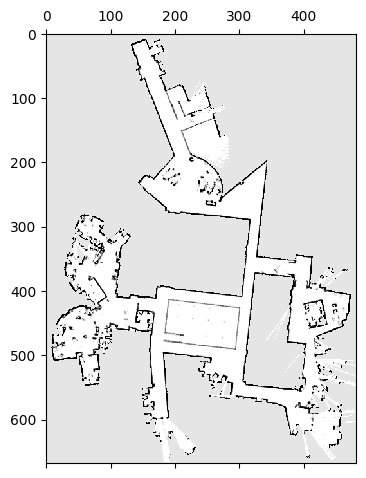

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import ex7 as ex
%matplotlib inline

data = pickle.load(open("dataset_mit_csail.p", "rb"))

plt.matshow(data['img_map'], cmap="gray")
plt.show()

The following data is provided in `data`:

- *img_map* is the image of the environment where the robot must localize
- *likelihood_map* is the likelihood map defined over the environment and used for computing the weights of the particles
- *odom* is the noisy odometry readings observed by the robot during navigation in the form: $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$
- *gt_odom* is the ground truth odometry, you may want to use it for checking your results
- *z* are the laser range measurements (37 beams $\rho_i, \phi_i$) obtained by the robot during navigation, where $\rho_i$ is the range and $\theta_i$ the corresponding firing angle defined wrt the robot orientation

You can access the `data` as follows:

In [2]:
# get odometry reading at timestep 25
odom_25 = data['odom'][25]
odom_26 = data['odom'][26]
print("Odom at step 25 is: ", odom_25)
print("Odom at step 26 is: ", odom_26)

# get ground truth odometry reading at timestep 25
odom_gt_25 = data['gt_odom'][25]
print("True odom at step 25 is: ", odom_gt_25)

# get observed scan at timestep 10
z_10 = data['z'][10]
print("Angles at step 10 is: ", z_10[0,:])
print("Ranges at step 10 is: ", z_10[1,:])

Odom at step 25 is:  [ 0.11378333  0.50803543 -0.18586595]
Odom at step 26 is:  [-0.12852936  0.3657966  -0.40221096]
True odom at step 25 is:  [ 0.08237367  0.53204367 -0.23049267]
Angles at step 10 is:  [-1.570796e+00 -1.483526e+00 -1.396256e+00 -1.308986e+00 -1.221716e+00
 -1.134446e+00 -1.047176e+00 -9.599060e-01 -8.726360e-01 -7.853660e-01
 -6.980960e-01 -6.108260e-01 -5.235560e-01 -4.362860e-01 -3.490160e-01
 -2.617460e-01 -1.744760e-01 -8.720600e-02  6.400000e-05  8.733400e-02
  1.746040e-01  2.618740e-01  3.491440e-01  4.364140e-01  5.236840e-01
  6.109540e-01  6.982240e-01  7.854940e-01  8.727640e-01  9.600340e-01
  1.047304e+00  1.134574e+00  1.221844e+00  1.309114e+00  1.396384e+00
  1.483654e+00  1.570924e+00]
Ranges at step 10 is:  [ 3.    2.99  1.33  1.23  1.16  1.14  1.34  1.43  1.4   2.94  3.    3.07
  3.2   3.22  3.59  3.7   3.86  2.75 81.91  1.65  1.68  1.81 81.91 81.91
  4.73  4.76  3.76  4.18  2.3   2.31  5.7   2.33  2.41  4.23  4.09  4.02
 81.91]


In [3]:
z_10.shape
# gonna use this for reshaping the input to the ranges2cells() function.

(2, 37)

In [4]:
print(type(data['likelihood_map']), data['likelihood_map'].shape, sep='\n')

<class 'numpy.ndarray'>
(668, 482)


In [5]:
print(type(data['odom']), len(data['odom']), data['odom'][10], type(data['gt_odom'][10]), data['gt_odom'][10].shape, sep='\n')

<class 'list'>
686
[-0.19652492  0.57600975 -0.19281769]
<class 'numpy.ndarray'>
(3,)


## 7.1 Motion update [2.0]

The `sample_motion_model_odometry` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$
- the odometry readings $u_t = [\delta_{rot1}, \delta_{trans}, \delta_{rot2}]$ 
- the noise parameters $\mathbf{\alpha} = [0.1, 0.1, 0.1, 0.1]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model_odometry` function and verify that it is correct for some test input. 

You **can** re-use the your implementation from Exercise 3. 

Let's test this function for the first 10 steps of the motion.

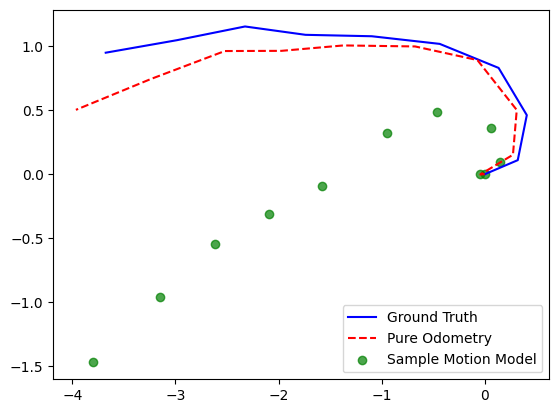

In [6]:
#### pure odometry ####
x_prior = np.array([0, 0, 0, 1])
x_pure_odom = [x_prior]

for i in range(10):
    del_rot_1, del_trans, del_rot_2 = data['odom'][i]
    x_post = ex.forward_motion_model(x_prior, del_rot_1, del_trans, del_rot_2)
    x_pure_odom.append(x_post)
    x_prior = x_post

x_p_o = [item[0] for item in x_pure_odom]
y_p_o = [item[1] for item in x_pure_odom]
#### ------------- ####



#### ground truth odometry ####
x_prior = np.array([0, 0, 0, 1])
x_ground_truth_odom = [x_prior]

for i in range(10):
    del_rot_1, del_trans, del_rot_2 = data['gt_odom'][i]
    x_post = ex.forward_motion_model(x_prior, del_rot_1, del_trans, del_rot_2)
    x_ground_truth_odom.append(x_post)
    x_prior = x_post

x_gt_odom = [item[0] for item in x_ground_truth_odom]
y_gt_odom = [item[1] for item in x_ground_truth_odom]
#### --------------------- ####



#### sample based odometry ####
x_prior = np.array([0, 0, 0, 1])
x_sample_based_odometry = [x_prior]
noise_parameters = [0.1, 0.1, 0.1, 0.1]

for i in range(10):
    x_post = ex.sample_motion_model_odometry(x_prior, data['odom'][i], noise_parameters)
    x_sample_based_odometry.append(x_post)
    x_prior = x_post

x_sample_o = [item[0] for item in x_sample_based_odometry]
y_sample_o = [item[1] for item in x_sample_based_odometry]
#### --------------------- ####

#### comparison ####
plt.plot(x_gt_odom, y_gt_odom, color='blue', label='Ground Truth')
plt.plot(x_p_o, y_p_o, color='red', linestyle='dashed', label='Pure Odometry')
plt.scatter(x_sample_o, y_sample_o, alpha=0.7, color='green', label='Sample Motion Model')
plt.legend()
plt.show()


This function is **better tested when ran multiple times. Kindly try it** and you'll get different results for the green dots each time (naturally!), but they all tend to be somewhere around the trajectory eventually.

## 7.2 Compute weights [6.0]

The `compute_weights` function is responsible for computing the importance weight for each particle according to the observation model, i.e.,

$$w_{i,t} = \eta\,p(z_{t}|x_{i,t}).$$

The motion model (I guess you mean the observation model!) is obtained by querying the likelihood map defined over the environment in the endpoints of the laser scan ranges.

The available `ranges2cells` function computes the endpoints of raw scans $(\rho, \phi)$ into map coordinates.

Implement the `compute_weights` function and verify that it is correct for some test input. 

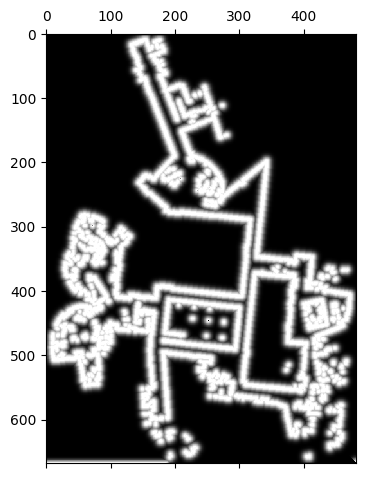

In [7]:
plt.matshow(data['likelihood_map'], cmap="gray")
plt.show()

In [8]:
poses = ex.init_uniform(4000, data['img_map'], map_res=0.1)
z_obs = data['z'][0]
gridmap = data['img_map']
likelihood_map = data['likelihood_map']
map_res = 0.1

weights = ex.compute_weights(poses, z_obs, gridmap, likelihood_map, map_res)
print(type(weights), weights.shape, sum(weights), max(weights), sep='\n')

<class 'numpy.ndarray'>
(4000, 1)
[1.]
[0.0031069]


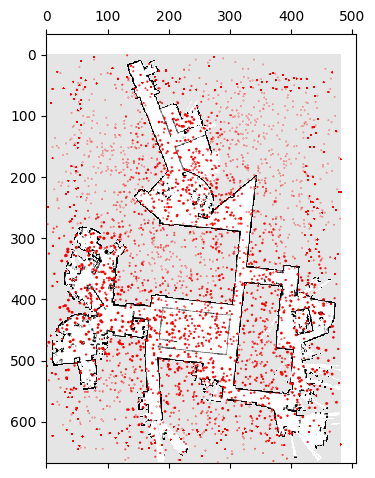

In [9]:
map_pose = []
for i in poses:
    map_pose.append(ex.world2map(i, data['img_map'], map_res))

x_coor_w = [pose[0] for pose in map_pose]
y_coor_w = [pose[1] for pose in map_pose]

plt.matshow(data['img_map'], cmap="gray")
plt.scatter(x_coor_w, y_coor_w, s = 700*weights[:,0], color='red')
plt.show()

Points of different sizes are clearly visible. For a clearer difference in point sizes simply reduce the number of points from 4000

## 7.3 Resampling [6.0]

The `resample` function is responsible for re-sampling particles according to their weight (the higher the more likely to be samples) and, thus, “kills” the particles with low weight.

Implement the `resample` function (low-variance resampling) and verify that it is correct for some test input. 

Using the randomly initialized particle set from the above cell:

In [10]:
resampled_particles = ex.resample(poses, weights, gridmap)

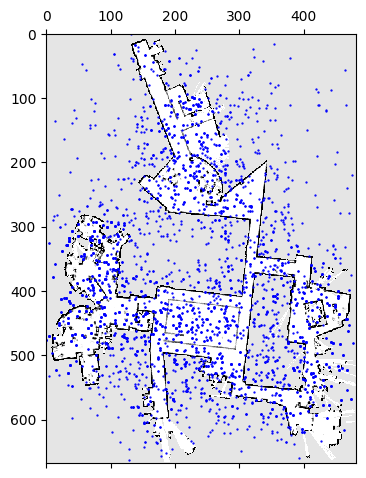

In [11]:
map_pose_resampled = []
for i in resampled_particles:
    map_pose_resampled.append(ex.world2map(i, data['img_map'], map_res))

x_resampled = [pose[0] for pose in map_pose_resampled]
y_resampled = [pose[1] for pose in map_pose_resampled]

plt.matshow(data['img_map'], cmap="gray")
plt.scatter(x_resampled, y_resampled, color='blue', s=0.4)
plt.show()

All points have equal size now. If some points seem more prominent, it's because they're infact multiple points plotted on top of eachother (points with higher weights in the previous stage that have been reproduced and are now at a higher in frequency). Also, trivial areas of the map are now visibly less crowded.

In [12]:
equal_samples = np.array([[1, 2, 0.0157, 1], [0, 5, -0.1, 1], [3, 3, 0.0, 1], [-2, 2, 0.3, 1]])
equal_weights = np.array([0.25, 0.25, 0.25, 0.25])
resampled_particles = ex.resample(equal_samples, equal_weights, data['img_map'])
print(resampled_particles)

[[ 1.      2.      0.0157  1.    ]
 [ 0.      5.     -0.1     1.    ]
 [ 3.      3.      0.      1.    ]
 [-2.      2.      0.3     1.    ]]


Particles with the equal weights end up with equal frequencies. Seems good!

## 7.4 Localization [6.0]

Once you complete all the above functions, implement the main procedure of Monte Carlo localization `mc_localization` which recursively estimate the position of the robot using the odometry data and the laser scans.

Consider 5000 particles that are intialized uniformly over the environment. 

The map resolution is 0.1 and each particle is a $(x,y,\theta)$ pose.

Plot the belief about the position of the robot after the sequence of odometry readings and laser scans provided in `data` by using the `plot_particles` function.

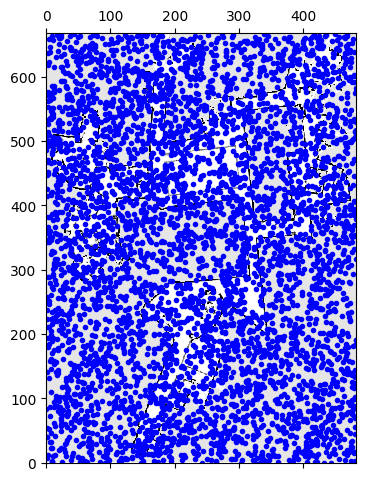

In [13]:
num_particles = 5000
map_res = 0.1

particles = ex.init_uniform(num_particles, data['img_map'], map_res)
ex.plot_particles(particles, data['img_map'], map_res)

In [14]:
odom = data['odom']
noise = [0.1, 0.1, 0.1, 0.1]
z = data['z']
gridmap = data['img_map']
likelihood_map = data['likelihood_map']
img_map = data['img_map'] # Although I think this is a useless variable


In [15]:
final_estimate = ex.mc_localization(odom, z, num_particles, particles, noise, gridmap, likelihood_map, map_res, img_map)

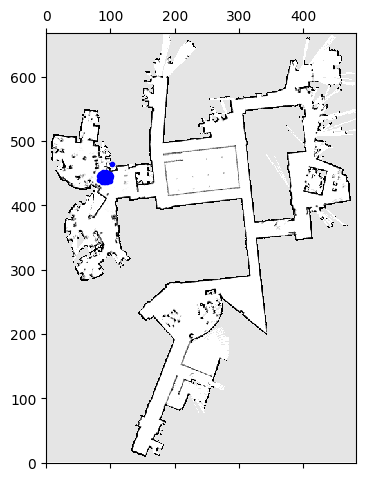

In [16]:
ex.plot_particles(final_estimate, img_map, map_res)

The coolest, yet the most painful :( exercise so far!